In [1]:
# https://aistudio.baidu.com/datasetdetail/141542 手动下载数据集
# !pip install matplotlib

# !export http_proxy=http://112.13.67.194:61111 && export https_proxy=http://112.13.67.194:61111
# !pip install einops
# pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
!export CUDA_LAUNCH_BLOCKING=1
import os
from pathlib import Path
import math
import torch
import torchvision
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, ModuleList
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

from einops import rearrange
from einops.layers.torch import Rearrange


import matplotlib.pyplot as plt
import PIL


In [2]:
class MyDataset(Dataset):
    def __init__(
        self,
        folder,
        image_size = 96,
        exts = ['jpg', 'jpeg', 'png', 'tiff']
    ):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for ext in exts for p in Path(f'{folder}').glob(f'**/*.{ext}')]

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),  # Scales data into [0,1]
            transforms.Lambda(lambda t: (t * 2) - 1),  # Scale between [-1, 1]
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = PIL.Image.open(path)
        return self.transform(img)


def show_img_batch(batch, num_samples=16, cols=4):
    reverse_transforms = transforms.Compose(
        [
            transforms.Lambda(lambda t: (t + 1) / 2), # [-1,1] -> [0,1]
            transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
            transforms.Lambda(lambda t: t * 255.0),
            transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ]
    )
    """Plots some samples from the dataset"""
    plt.figure(figsize=(10, 10))
    for i in range(batch.shape[0]):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(reverse_transforms(batch[i, :, :, :]))
    plt.show()



# dataset = MyDataset("/data/dataset/img_align_celeba")
# # drop_last 保证 batch_size 一致
# loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

# for batch in loader:
#     show_img_batch(batch)
#     break

In [3]:
#时间转向量
class SinusoidalPosEmb(Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# 每个channel方差标准化
class RMSNorm(Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * self.scale
    

class Block(Module):
    def __init__(self, dim, dim_out, up = False, dropout = 0.001):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups=32, num_channels=dim) # 总通道dim，分为32组 
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, scale_shift = None):
        x = self.norm(x)
        x = self.proj(x)

        if (scale_shift is not None):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return self.dropout(x)

# 在通道上做注意力，channel 相当于 seq_len
class Attention(Module):
    def __init__(
        self,
        dim,
        heads = 4
    ):
        super().__init__()
        # 这里做了简化 dim_head 可以作为参数传入
        dim_head = dim // heads
        
        self.scale = dim_head ** -0.5
        self.heads = heads
        # 这里把channel变换到固定尺寸进行qkv点积然后还原channel。 
        # channel -> hidden_dim(dim_head * heads) -> qkv -> channel
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)
        
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            RMSNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape

        res = x
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        # 把 (h, w) 拉成一维 相当于一个token，channel 就是 token 数量
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = F.scaled_dot_product_attention(q, k, v)
        
        out = rearrange(q, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        #(h c) = hidden_dim, b (h c) x y -> b, c, h, w
        return self.to_out(out)



class AttnBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_mlp_dim, up=False, isLast = False):
        super().__init__()
        # 使用 AdaLN 生成 scale, shift 这里输出channel乘2再拆分
        self.time_condition = nn.Sequential(
            nn.Linear(time_mlp_dim, time_mlp_dim),
            nn.SiLU(),
            nn.Linear(time_mlp_dim, out_ch * 2)
        )
        self.norm1 = nn.GroupNorm(num_groups=32, num_channels=in_ch)
        self.norm2 = nn.GroupNorm(num_groups=32, num_channels=out_ch)
        self.act1 = nn.SiLU()
        self.short_cut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

        # self.attention = Attention(out_ch, heads = 4)

        if up:
            self.sample = nn.Sequential(
                                nn.Upsample(scale_factor = 2, mode = 'nearest'), # 直接插值，原地卷积
                                nn.Conv2d(in_ch, in_ch, 3, padding = 1)
                            )
        else: # down
            self.sample = nn.Conv2d(in_ch, in_ch, 3, 2, 1)

            
        if isLast: # 最底层不缩放
            self.sample = nn.Conv2d(out_ch, out_ch, 3, padding = 1)

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1, groups=32)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)

        self.dropout = nn.Dropout(0.01)

        
    def forward(self, x, time_emb):
        x = self.norm1(x)
        
        h = self.sample(x)
        x = self.sample(x)
        

        h = self.act1(h)
        h = self.conv1(h)

        # (b, time_mlp_dim) -> (b, c+c)
        time_emb = self.time_condition(time_emb)
        time_emb = rearrange(time_emb, 'b c -> b c 1 1') # b c+c 1 1
        scale, shift = time_emb.chunk(2, dim = 1)

        h = h * (scale + 1) + shift

        h = self.norm2(h)
        h = self.act1(h)
        h = self.conv2(h)
        

        h = self.dropout(h)
        
        h = h + self.short_cut(x)

        return h


class Unet(Module):
    def __init__(
        self,
        image_channel = 3,
        init_dim = 32,
        down_channels = [(32, 64), (64, 128), (128, 256), (256, 512)],
        up_channels = [(512+512, 256), (256+256, 128), (128+128, 64), (64+64, 32)], #这里需要跳跃拼接，所以输入维度有两个拼一起
    ):
        super().__init__()
        self.init_conv = nn.Conv2d(image_channel, init_dim, 7, padding = 3)

        time_pos_dim = 32
        time_mlp_dim = time_pos_dim * 4
        self.time_mlp = nn.Sequential(
                SinusoidalPosEmb(time_pos_dim),
                nn.Linear(time_pos_dim, time_mlp_dim),
                nn.GELU()
                )

        self.downs = ModuleList([])
        self.ups = ModuleList([])

        for i in range(len(down_channels)):
            down_in, down_out = down_channels[i]
            isLast = len(down_channels)-1 == i # 底部
            self.downs.append(AttnBlock(down_in, down_out, time_mlp_dim, up=False, isLast=False))


        for i in range(len(up_channels)):
            up_in, up_out = up_channels[i]
            isLast = 0 == i # 底部
            self.ups.append(AttnBlock(up_in, up_out, time_mlp_dim, up=True, isLast=False))


        self.output = nn.Conv2d(init_dim, image_channel, 1)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) #初始化权重


    def forward(self, img, time):
        # 时间转向量 time (b, 1) -> (b, time_mlp_dim)
        time_emb = self.time_mlp(time)

        x = self.init_conv(img)
        
        skip_connect = []
        for down in self.downs:
            x = down(x, time_emb)
            skip_connect.append(x)

        for up in self.ups:
            x = torch.cat((x, skip_connect.pop()), dim=1) #先在通道上拼接 再输入
            x = up(x, time_emb)

        return self.output(x)


# device = "cuda"
# model = Unet().to(device)
# img_size = 64
# img = torch.randn((1, 3, img_size, img_size)).to(device)
# time = torch.tensor([4]).to(device)
# print(model(img, time).shape)        

预测噪声损失 $\Vert \bar{\varepsilon}_0 - \hat{\epsilon}_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \bar{\varepsilon}_0,t) \Vert_2^2$
  
最大时间步 $T=1000$  
加噪过程，每次只加入少许噪声，加噪至最后图片已经接近纯噪声需要稍微加大噪声。  
确定取值范围 $\beta_t \in [0.0001, 0.02]$ 令 $\bar{\beta_t}={1-\bar{\alpha}_t}$  
  
模型输入参数：  
img = $(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \bar{\varepsilon}_0)$   
time = $t$


In [4]:
# t = torch.tensor([[1,2,3],
#                   [4,5,6],
#                   [7,8,9]])
# index = torch.tensor([[0,1,2],
#                       [1,0,0],
#                       [2,0,0]])
# t -> H x W
# t.gather(-1, index) # 按每行的坐标进行取值
# tensor([[1, 2, 3],
#         [5, 4, 4],
#         [9, 7, 7]])

# t.gather(-2, index) # 按每列的坐标进行取值
# tensor([[1, 5, 9],
#         [4, 2, 3],
#         [7, 2, 3]])


In [5]:
image_size=96
epochs = 500
batch_size = 128
device = 'cuda'
T=1000
betas = torch.linspace(0.0001, 0.02, T).to('cuda') # torch.Size([1000])

# train
alphas = 1 - betas # 0.9999 -> 0.98
alphas_cumprod = torch.cumprod(alphas, axis=0) # 0.9999 -> 0.0000
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) 
sqrt_one_minus_alphas_cumprod = torch.sqrt(1-alphas_cumprod)

def get_val_by_index(val, t, x_shape):
    batch_t = t.shape[0]
    out = val.gather(-1, t)
    return out.reshape(batch_t, *((1,) * (len(x_shape) - 1))) # torch.Size([batch_t, 1, 1, 1])

def q_sample(x_0, t, noise):
    device = x_0.device

    sqrt_alphas_cumprod_t = get_val_by_index(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_val_by_index(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    noised_img = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    return noised_img


# 校验输入的噪声图片
def print_noised_img():
    # print(alphas)
    # print(sqrt_alphas_cumprod)
    # print(sqrt_one_minus_alphas_cumprod)
    test_dataset = MyDataset("/data/dataset/img_align_celeba", image_size=96)
    # drop_last 保证 batch_size 一致
    test_loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)
    for batch in test_loader:
        test_img = batch.to(device)
        # img = torch.randn((batch_size, 3, 64, 64)).to(device)
        time = torch.randint(190, 191, (1,), device=device).long()
        out = get_val_by_index(sqrt_alphas_cumprod, time, img.shape)
        # print('out', out)
        noise = torch.randn_like(test_img, device=img.device)
        # print('noise', noise, torch.mean(noise))
        noised_img = q_sample(test_img, time, noise)
        # print(noised_img.shape)
        show_img_batch(noised_img.detach().cpu())
        break


In [6]:
def train(checkpoint_prefix=None, start_epoch = 0):
    dataset = MyDataset("/data/dataset/img_align_celeba", image_size=image_size)
    # drop_last 保证 batch_size 一致
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    model = Unet().to(device)
    if start_epoch > 0:
        model.load_state_dict(torch.load(f'{checkpoint_prefix}_{start_epoch}.pth'))
    
    # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
    
    for epoch in range(epochs):
        epoch += 1
        batch_idx = 0
        for batch in loader:
            batch_idx += 1

            img = batch.to(device)
            time = torch.randint(0, T, (batch_size,), device=device).long()
            noise = torch.randn_like(img, device=img.device)
            noised_img = q_sample(img, time, noise)
            noise_pred = model(noised_img, time)
            # loss = F.mse_loss(noise, noise_pred, reduction='sum')
            loss = (noise - noise_pred).square().sum(dim=(1, 2, 3)).mean(dim=0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+start_epoch} | Batch index {batch_idx:03d} Loss: {loss.item()}")
        
        if epoch % 100 == 0:
            torch.save(model.state_dict(), f'{checkpoint_prefix}_{start_epoch+epoch}.pth')
    

# train(checkpoint_prefix='ddpm_T1000_l2_epochs', start_epoch = 0)

Epoch 1 | Batch index 100 Loss: 20164.40625  
...
Epoch 300 | Batch index 100 Loss: 343.15917

训练完成后,从模型中采样图片
$x_{t-1}=\dfrac{1}{\sqrt{{\alpha}_t}}\left( x_t - \dfrac{1-{\alpha}_{t}}{\sqrt{1-\bar{\alpha}_t}}\hat{\epsilon}_\theta(x_t,t) \right) + \sigma_q(t) \mathrm{z} $

$\sigma^2_q(t)={\dfrac{(1-{\alpha}_{t})(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_{t}}}$ ，则 $\sigma_q(t)=\sqrt{\dfrac{(1-{\alpha}_{t})(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_{t}}}$ 且 t=1 时，$\sigma_q(t)=0$

In [7]:
torch.cuda.empty_cache()
model = Unet().to(device)
model.load_state_dict(torch.load('ddpm_T1000_l2_epochs_300.pth'))
model.eval()
print("")

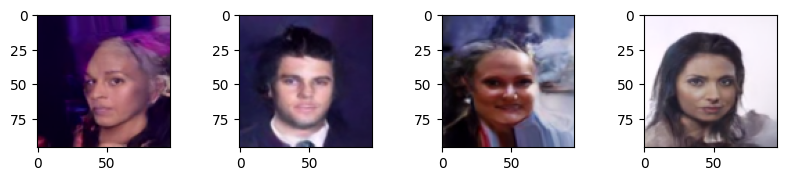

In [30]:
# 计算去噪系数
one_divided_sqrt_alphas  = 1 / torch.sqrt(alphas)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod

# 计算方差
alphas_cumprod = alphas_cumprod
# 去掉最后一位，(1, 0)表示左侧 填充 1.0, 表示 alphas t-1
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

std_variance_q = torch.sqrt((1-alphas) * (1-alphas_cumprod_prev) / (1-alphas_cumprod))


def p_sample_ddpm(model):
    def step_denoise(model, x_t, t):
        one_divided_sqrt_alphas_t = get_val_by_index(one_divided_sqrt_alphas, t, x_t.shape)
        one_minus_alphas_t = get_val_by_index(1-alphas, t, x_t.shape)
        one_minus_alphas_cumprod_t = get_val_by_index(sqrt_one_minus_alphas_cumprod, t, x_t.shape)
        
        mean = one_divided_sqrt_alphas_t * (x_t - (one_minus_alphas_t / one_minus_alphas_cumprod_t * model(x_t, t)))
        
        std_variance_q_t = get_val_by_index(std_variance_q, t, x_t.shape)

        if t == 0:
            return mean
        else:
            noise_z = torch.randn_like(x_t, device=x_t.device)
            return mean + std_variance_q_t * noise_z

    
    img_pred = torch.randn((4, 3, image_size, image_size), device=device)
    for i in reversed(range(0, T)):
        t = torch.tensor([i], device=device, dtype=torch.long)
        img_pred = step_denoise(model, img_pred, t)
        # print(img_pred.mean())
        # 每步截断效果比较差
        # if i % 200 == 0:
        #     img_pred = torch.clamp(img_pred, -1.0, 1.0)
        torch.cuda.empty_cache()


    return img_pred

with torch.no_grad():
    img = p_sample_ddpm(model)
    img = torch.clamp(img, -1.0, 1.0)

show_img_batch(img.detach().cpu())